In [ ]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs
%cd "/content/Self-Correction-Human-Parsing/inputs"
!mkdir data
%cd ..

Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 719 (delta 73), reused 64 (delta 64), pack-reused 546
Receiving objects: 100% (719/719), 3.88 MiB | 18.22 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/Self-Correction-Human-Parsing
/content/Self-Correction-Human-Parsing/inputs
/content/Self-Correction-Human-Parsing


In [ ]:
dataset = 'lip'         #select from ['lip', 'atr', 'pascal']

In [ ]:
import gdown

if dataset == 'lip':
    url = 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH'
elif dataset == 'atr':
    url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
elif dataset == 'pascal':
    url = 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE'

output = 'checkpoints/final.pth'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=5f3a9ec7-deb0-4e57-b5ec-a80441a07b33
To: /content/Self-Correction-Human-Parsing/checkpoints/final.pth
100%|██████████| 267M/267M [00:01<00:00, 158MB/s]


'checkpoints/final.pth'

In [ ]:
!python3 simple_extractor.py --dataset 'lip' --model-restore 'checkpoints/final.pth' --input-dir 'inputs/data' --output-dir 'outputs' --logits

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2, random

In [ ]:
image = "00006_00_00006_00"

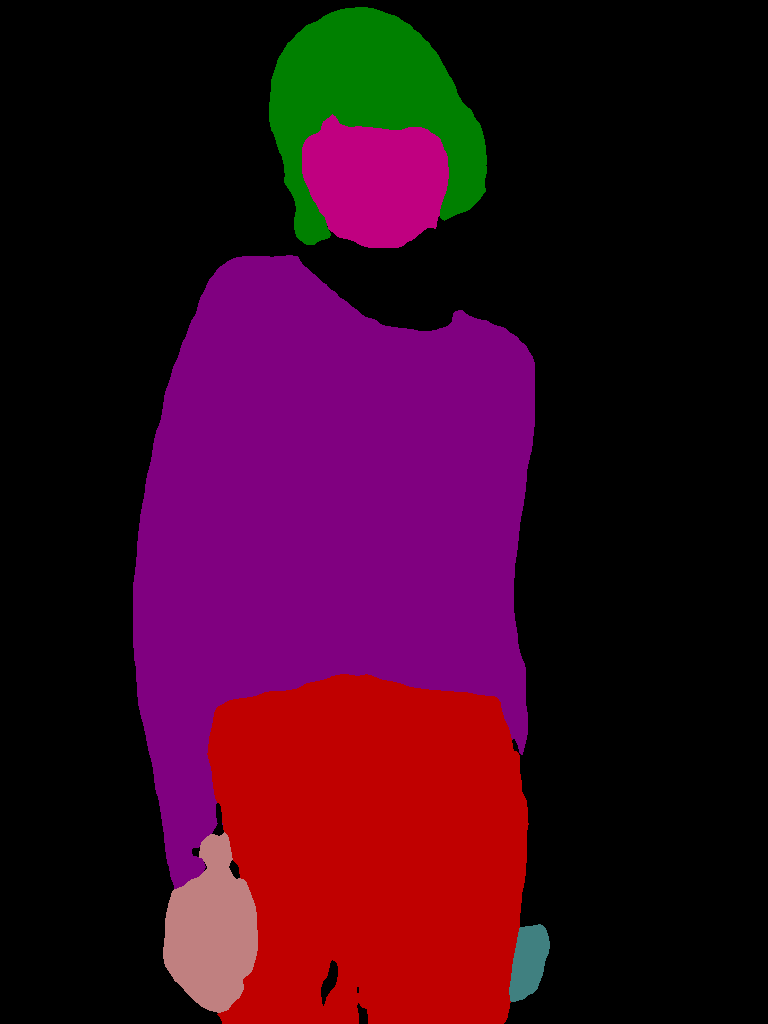

In [ ]:
parsing_image = cv2.imread(f"/content/Self-Correction-Human-Parsing/outputs/{image}.png")
cv2_imshow(parsing_image)

In [ ]:
dataset = np.load(f'/content/Self-Correction-Human-Parsing/outputs/{image}.npy', encoding='bytes')
dataset.shape

(1024, 768, 20)

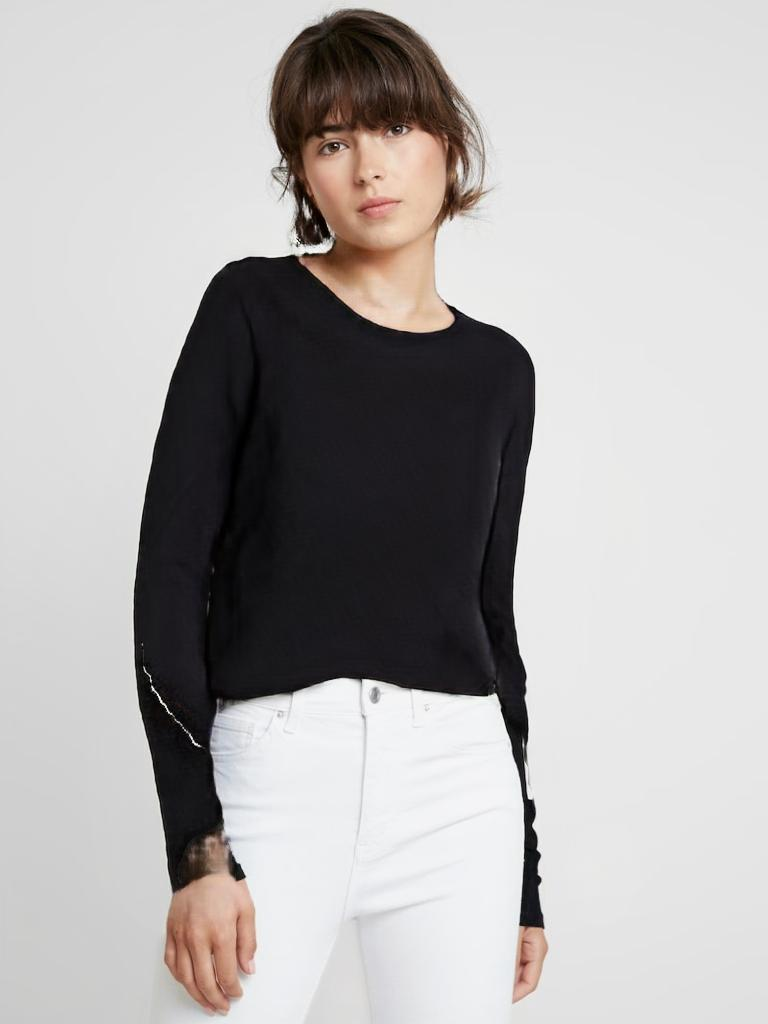

In [ ]:
input_image = cv2.imread(f"/content/Self-Correction-Human-Parsing/inputs/data/{image}.png")
cv2_imshow(input_image)

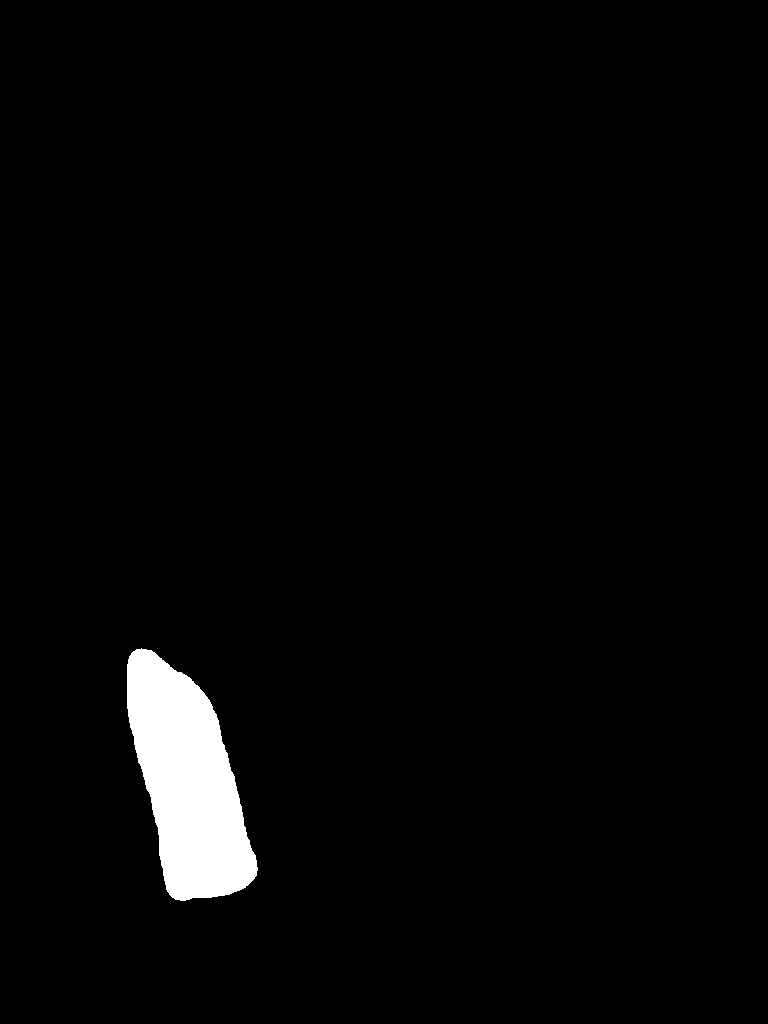

In [ ]:
mask = cv2.imread("/content/Self-Correction-Human-Parsing/inputs/mask.jpg")
cv2_imshow(mask)

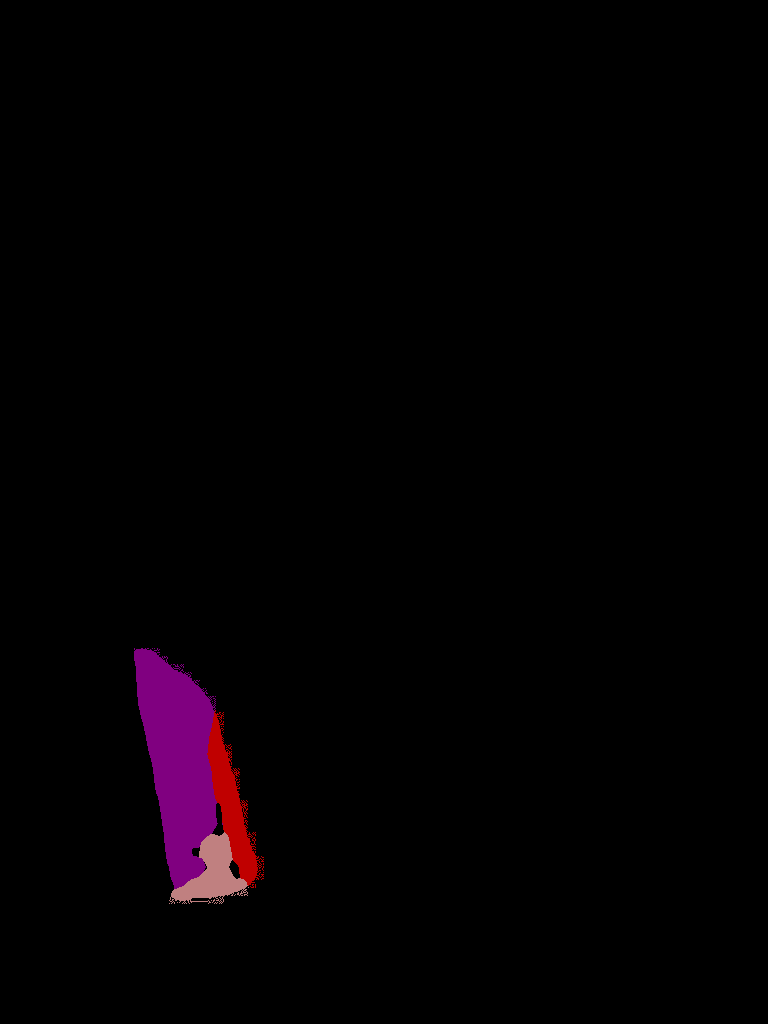

In [ ]:
# Overlay the mask on the parsing image
overlay = cv2.bitwise_and(parsing_image, parsing_image, mask=mask[:,:,2])
cv2_imshow(overlay)


In [ ]:
layers = {}
for class_index in range(dataset.shape[-1]):

    class_data  = dataset[:, :, class_index]

    threshold = 6
    # Create a mask based on the threshold
    class_data_mask = class_data >= threshold

    class_data_pixels = parsing_image.copy()
    class_data_pixels[~class_data_mask] = 0
    # cv2_imshow(class_data_pixels)


    overlap = cv2.bitwise_and(class_data_pixels, class_data_pixels, mask=mask[:,:,2])

    if np.any(overlap):
      # cv2_imshow(overlap)
      # layers.append(overlap)
      layers[class_index] = overlap
      print(class_index)

5
9
15


Find max Class

In [ ]:
max_class_index = 0
max_layer = layers.get(max_class_index)
max_area = 0
for class_index, layer in layers.items():

  # Convert the image to grayscale
  gray_mask = cv2.cvtColor(layer, cv2.COLOR_BGR2GRAY)
  # Ensure it's a binary mask (if not, you might need to threshold it)
  _, binary_mask = cv2.threshold(gray_mask, 5, 255, cv2.THRESH_BINARY)
  # Calculate the area of the mask
  mask_area = np.sum(binary_mask / 255)  # Divide by 255 to get the count of foreground pixels

  if mask_area > max_area:
    max_area = mask_area
    max_layer = layer
    max_class_index = class_index


print(max_area)
print(max_class_index)
# cv2_imshow(max_layer)

10995.0
5


['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']

In [ ]:
label_list = ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']

In [ ]:
label_list[5]

'Upper-clothes'

Crop classes

(no need)

In [ ]:
gray_mask = cv2.cvtColor(max_layer, cv2.COLOR_BGR2GRAY)
output_image = cv2.bitwise_and(input_image, input_image, mask=gray_mask)


cv2_imshow(output_image)

Ask BLIP what color are the classes

(Input the original image)

In [ ]:
! pip install replicate

In [ ]:
import replicate
import os

os.environ["REPLICATE_API_TOKEN"] = "r8_TpwxvWqeqdwL8BTbKj8YamBWtY45p0L36dI8e"

replicate = replicate.Client(api_token='')

In [ ]:
blip_image = open(f"/content/Self-Correction-Human-Parsing/inputs/data/{image}.png", "rb")

output = replicate.run(
  "salesforce/blip:2e1dddc8621f72155f24cf2e0adbde548458d3cab9f00c0139eea840d0ac4746",
  input={
    "image": blip_image,
    "task": "visual_question_answering",
    "question": f"what is the color of {label_list[max_class_index]}"
  }
)
text = ' '.join(output.split(' ')[1:])
text

'black'

In [ ]:
final_prompt = f"a photograph of a {text} {label_list[max_class_index]}"
final_prompt

'a photograph of a black Upper-clothes'